# Présentation Partie 1 - Exploration rapide des données

## Objectif : Analyser et comprendre le dataset

In [27]:
# Setup rapide
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration affichage
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

## 1. Chargement des données

In [28]:
# Chargement dataset
df = pd.read_csv('../data/raw/creditcard.csv')

print("DATASET CREDIT CARD FRAUD DETECTION")
print("=" * 40)
print(f" Taille: {df.shape[0]:,} transactions x {df.shape[1]} variables")
print(f" Mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f" Valeurs manquantes: {df.isnull().sum().sum()}")

# Structure rapide
print(f"\n Variables:")
print(f"   • V1-V28: Features anonymisées (transformation PCA)")
print(f"   • Time: Temps depuis 1ère transaction (secondes)")
print(f"   • Amount: Montant en euros")
print(f"   • Class: 0=Normal, 1=Fraude")

DATASET CREDIT CARD FRAUD DETECTION
 Taille: 284,807 transactions x 31 variables
 Mémoire: 67.4 MB
 Valeurs manquantes: 0

 Variables:
   • V1-V28: Features anonymisées (transformation PCA)
   • Time: Temps depuis 1ère transaction (secondes)
   • Amount: Montant en euros
   • Class: 0=Normal, 1=Fraude


## 2. Le défi principal : un déséquilibre extrême

DÉSÉQUILIBRE DES CLASSES
Normales: 284,315 (99.83%)
Fraudes:  492 (0.173%)
Ratio: 1:578

 Impact: Le modèle aura tendance à prédire 'normale' par défaut


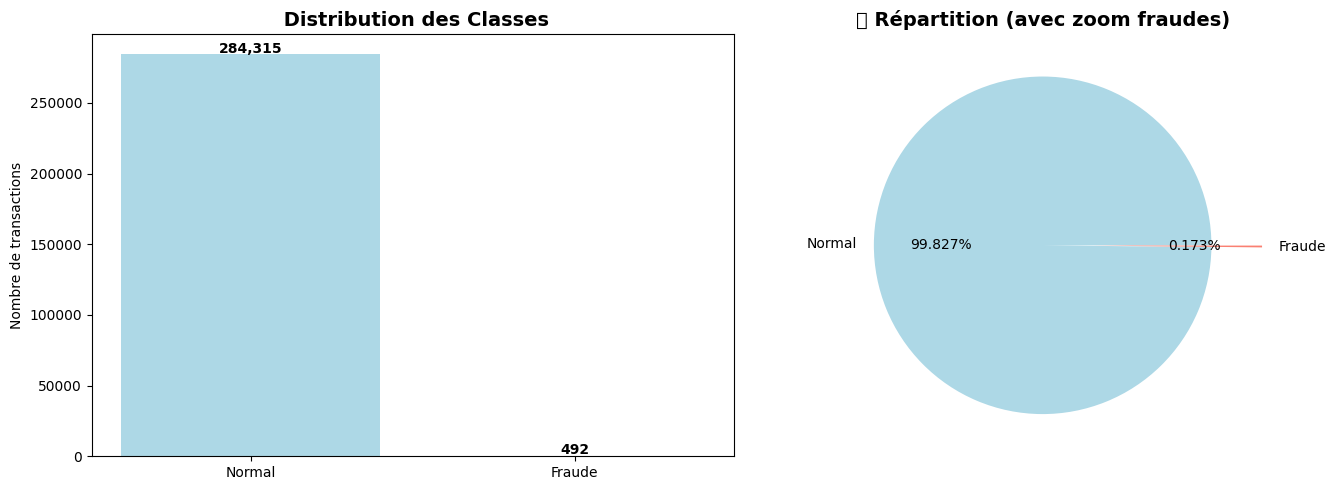


 Enjeu: Comment entraîner un modèle avec seulement 0.173% de fraudes ?


In [29]:
# Analyse du déséquilibre
class_counts = df['Class'].value_counts()
total = len(df)

print("DÉSÉQUILIBRE DES CLASSES")
print("=" * 30)
print(f"Normales: {class_counts[0]:,} ({class_counts[0]/total*100:.2f}%)")
print(f"Fraudes:  {class_counts[1]:,} ({class_counts[1]/total*100:.3f}%)")
print(f"Ratio: 1:{class_counts[0]/class_counts[1]:.0f}")
print(f"\n Impact: Le modèle aura tendance à prédire 'normale' par défaut")

# Visualisation du déséquilibre
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
bars = ax1.bar(['Normal', 'Fraude'], class_counts, color=['lightblue', 'salmon'])
ax1.set_title(' Distribution des Classes', fontsize=14, fontweight='bold')
ax1.set_ylabel('Nombre de transactions')
for i, v in enumerate(class_counts):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# Graphique en secteurs avec zoom sur fraudes
wedges, texts, autotexts = ax2.pie(class_counts, labels=['Normal', 'Fraude'], 
                                   autopct='%1.3f%%', colors=['lightblue', 'salmon'],
                                   explode=(0, 0.3))  # Explosion pour mettre en évidence
ax2.set_title('📊 Répartition (avec zoom fraudes)', fontsize=14, fontweight='bold')

plt.tight_layout()

# Sauvegarde avec fond blanc
plt.savefig("img/repartition.png", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()

print(f"\n Enjeu: Comment entraîner un modèle avec seulement {class_counts[1]/total*100:.3f}% de fraudes ?")

## 3. Patterns dans les montants

 ANALYSE DES MONTANTS
Normal - Moyenne: 88.29€ | Médiane: 22.00€
Fraude - Moyenne: 122.21€ | Médiane: 9.25€

 Insight: Les montants des fraudes sont généralement plus faibles (médiane) mais quelques fraudes à très gros montants tirent la moyenne vers le haut


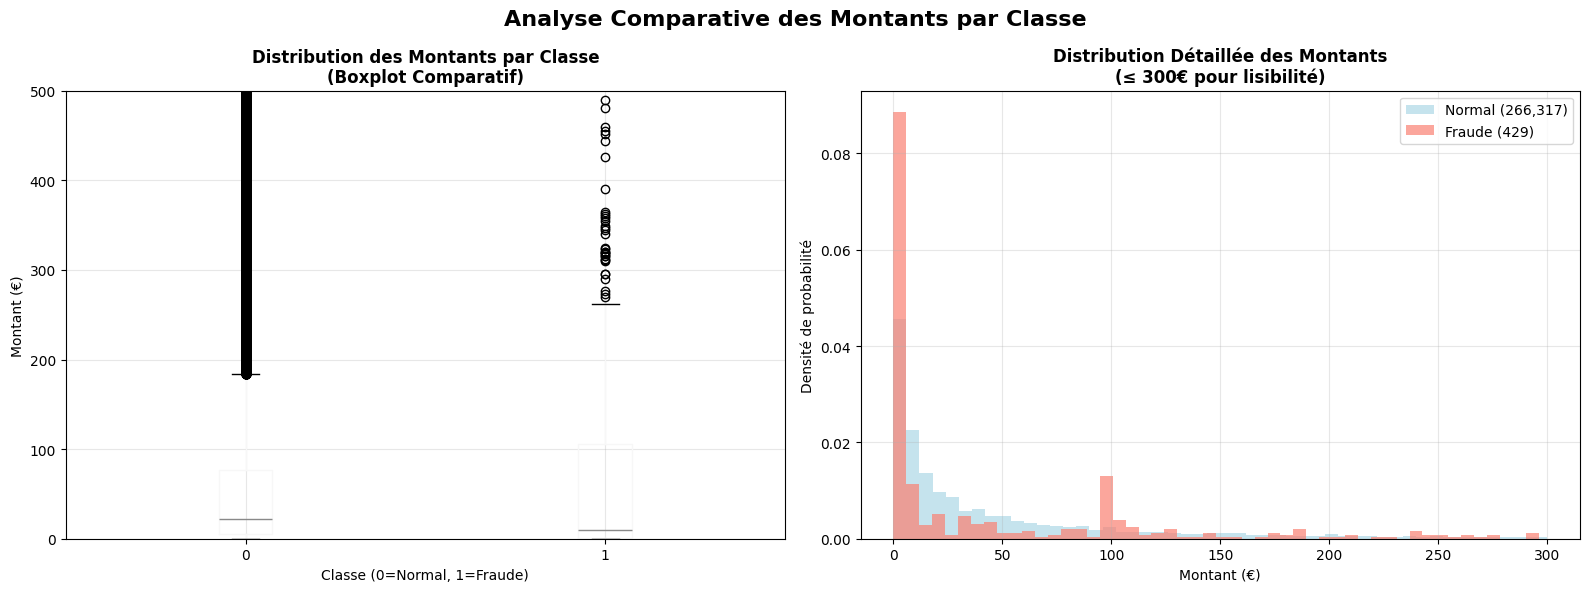

 Observations détaillées:
   • Boxplot: Médiane fraudes (9€) << Médiane normales (22€)
   • Outliers: Plus de valeurs extrêmes dans les transactions normales
   • Concentration: Fraudes concentrées sur petits montants (0-50€)
   • Justification: Cette différence justifie la création d'Amount_Category


In [30]:
# Analyse des montants par classe
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

print(" ANALYSE DES MONTANTS")
print("=" * 25)
print(f"Normal - Moyenne: {normal_amounts.mean():.2f}€ | Médiane: {normal_amounts.median():.2f}€")
print(f"Fraude - Moyenne: {fraud_amounts.mean():.2f}€ | Médiane: {fraud_amounts.median():.2f}€")
print(f"\n Insight: Les montants des fraudes sont généralement plus faibles (médiane) mais quelques fraudes à très gros montants tirent la moyenne vers le haut")

# Visualisation comparative - BOXPLOT + HISTOGRAMME
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. BOXPLOT - Comparaison distribution montants (échelle normale pour lisibilité)
df.boxplot(column='Amount', by='Class', ax=ax1)
ax1.set_title('Distribution des Montants par Classe\n(Boxplot Comparatif)', fontweight='bold')
ax1.set_xlabel('Classe (0=Normal, 1=Fraude)')
ax1.set_ylabel('Montant (€)')
ax1.set_ylim(0, 500)  # Limite à 500€ pour meilleure lisibilité
ax1.grid(True, alpha=0.3)

# 2. HISTOGRAMME - Distribution détaillée (≤ 300€)
amounts_filtered_normal = normal_amounts[normal_amounts <= 300]
amounts_filtered_fraud = fraud_amounts[fraud_amounts <= 300]

ax2.hist(amounts_filtered_normal, bins=50, alpha=0.7, label=f'Normal ({len(amounts_filtered_normal):,})',
        color='lightblue', density=True)
ax2.hist(amounts_filtered_fraud, bins=50, alpha=0.7, label=f'Fraude ({len(amounts_filtered_fraud):,})',
        color='salmon', density=True)
ax2.set_xlabel('Montant (€)')
ax2.set_ylabel('Densité de probabilité')
ax2.set_title('Distribution Détaillée des Montants\n(≤ 300€ pour lisibilité)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Analyse Comparative des Montants par Classe', fontsize=16, fontweight='bold')
plt.tight_layout()

# Sauvegarde avec fond blanc pour slides
plt.savefig("img/amount_analysis.png", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()

print(f" Observations détaillées:")
print(f"   • Boxplot: Médiane fraudes ({fraud_amounts.median():.0f}€) << Médiane normales ({normal_amounts.median():.0f}€)")
print(f"   • Outliers: Plus de valeurs extrêmes dans les transactions normales")
print(f"   • Concentration: Fraudes concentrées sur petits montants (0-50€)")
print(f"   • Justification: Cette différence justifie la création d'Amount_Category")

## 4. Patterns temporels

 ANALYSE TEMPORELLE
 Durée: 2.0 jours
 Heures: 0h à 24h


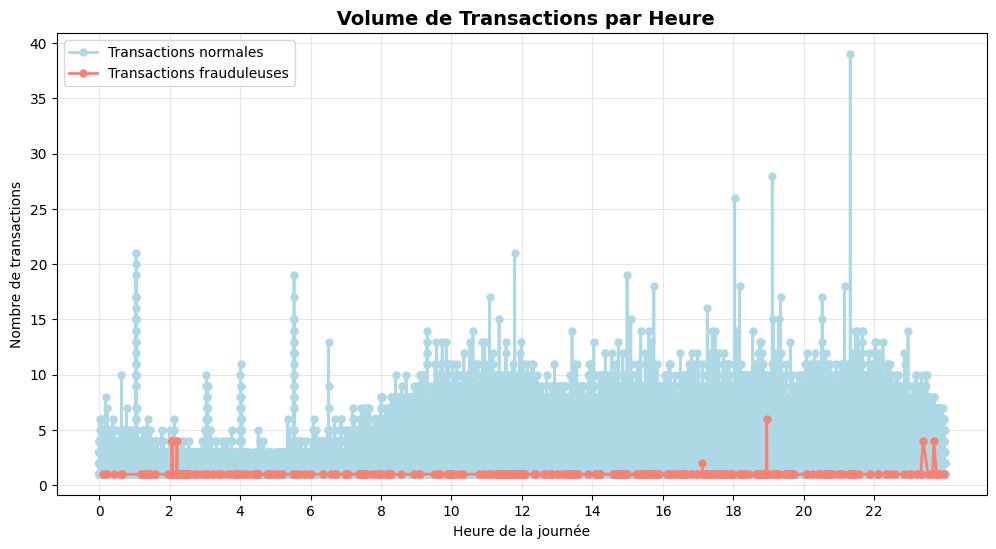


 Observations temporelles:
   • Pic d'activité normale: journée (8h-20h)
   • Activité nocturne réduite mais fraudes présentes
   • Les fraudes suivent grossièrement les patterns normaux

 Insight: L'information temporelle (heure) pourrait être une feature utile même si les patterns fraude/normal sont similaires


In [31]:
# Analyse temporelle
df['Hour'] = (df['Time'] / 3600) % 24
df['Day'] = df['Time'] // 86400

print(" ANALYSE TEMPORELLE")
print("=" * 20)
print(f" Durée: {df['Time'].max()/3600/24:.1f} jours")
print(f" Heures: {df['Hour'].min():.0f}h à {df['Hour'].max():.0f}h")

# Pattern par heure
hourly_fraud = df[df['Class']==1].groupby('Hour').size()
hourly_normal = df[df['Class']==0].groupby('Hour').size()

plt.figure(figsize=(12, 6))
plt.plot(hourly_normal.index, hourly_normal.values, 'o-', label='Transactions normales',
         color='lightblue', linewidth=2, markersize=5)
plt.plot(hourly_fraud.index, hourly_fraud.values, 'o-', label='Transactions frauduleuses',
         color='salmon', linewidth=2, markersize=5)
plt.xlabel('Heure de la journée')
plt.ylabel('Nombre de transactions')
plt.title(' Volume de Transactions par Heure', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.show()

print(f"\n Observations temporelles:")
print(f"   • Pic d'activité normale: journée (8h-20h)")
print(f"   • Activité nocturne réduite mais fraudes présentes")
print(f"   • Les fraudes suivent grossièrement les patterns normaux")

print(f"\n Insight: L'information temporelle (heure) pourrait être une feature utile même si les patterns fraude/normal sont similaires")

## 5. Features anonymisées les plus prédictives

 TOP 5 FEATURES ANONYMISÉES LES PLUS PRÉDICTIVES
Méthodologie: Corrélation absolue avec la variable 'Class'
Plus la corrélation est élevée, plus la feature discrimine fraude/normal

1. V17: 0.326 (corrélation absolue)
2. V14: 0.303 (corrélation absolue)
3. V12: 0.261 (corrélation absolue)
4. V10: 0.217 (corrélation absolue)
5. V16: 0.197 (corrélation absolue)


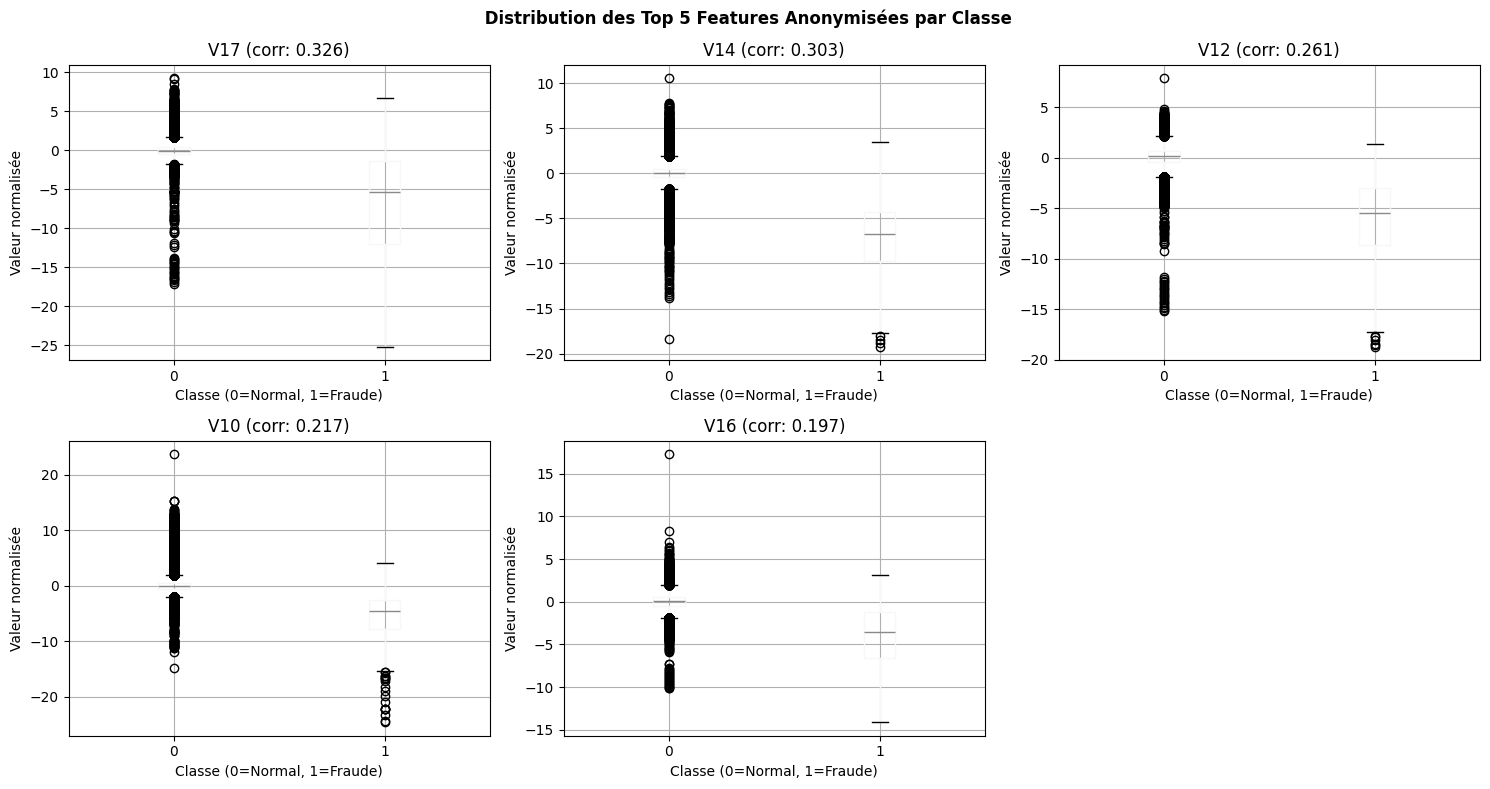


 Qu'est-ce que PCA ?
   • PCA = Principal Component Analysis (Analyse en Composantes Principales)
   • Technique qui transforme les données originales en nouvelles variables (V1-V28)
   • But: Réduire la dimensionalité tout en gardant l'information importante
   • Ici utilisé pour anonymiser les vraies features (montant, lieu, type carte, etc.)

 Ces 5 features montrent des distributions très différentes entre fraudes et transactions normales


In [32]:
# Top corrélations avec Class
v_features = [col for col in df.columns if col.startswith('V')]
correlations = df[v_features + ['Class']].corr()['Class'].abs().sort_values(ascending=False)

print(" TOP 5 FEATURES ANONYMISÉES LES PLUS PRÉDICTIVES")
print("=" * 50)
print("Méthodologie: Corrélation absolue avec la variable 'Class'")
print("Plus la corrélation est élevée, plus la feature discrimine fraude/normal\n")

top_features = correlations.head(6)[1:]  # Exclure Class elle-même
for i, (feature, corr) in enumerate(top_features.items(), 1):
    print(f"{i}. {feature}: {corr:.3f} (corrélation absolue)")

# Visualisation des top 5 features seulement
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Afficher seulement les 5 premiers features
for i, feature in enumerate(top_features.index[:5]):
    df.boxplot(column=feature, by='Class', ax=axes[i])
    axes[i].set_title(f'{feature} (corr: {top_features[feature]:.3f})')
    axes[i].set_xlabel('Classe (0=Normal, 1=Fraude)')
    axes[i].set_ylabel('Valeur normalisée')

# Supprime le 6ème subplot vide
fig.delaxes(axes[5])

plt.suptitle(' Distribution des Top 5 Features Anonymisées par Classe', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n Qu'est-ce que PCA ?")
print(f"   • PCA = Principal Component Analysis (Analyse en Composantes Principales)")
print(f"   • Technique qui transforme les données originales en nouvelles variables (V1-V28)")
print(f"   • But: Réduire la dimensionalité tout en gardant l'information importante")
print(f"   • Ici utilisé pour anonymiser les vraies features (montant, lieu, type carte, etc.)")
print(f"\n Ces 5 features montrent des distributions très différentes entre fraudes et transactions normales")

## 6. Résumé et prochaines étapes

In [33]:
print(" RÉSUMÉ - PARTIE 1")
print("=" * 20)
print(f" Dataset validé: {len(df):,} transactions, {df.shape[1]} variables")
print(f" Qualité parfaite: 0 valeurs manquantes")
print(f"️ DÉFI MAJEUR: Déséquilibre extrême 1:{class_counts[0]/class_counts[1]:.0f}")
print(f"\n VARIABLES CRÉÉES:")
print(f"   • Hour: Heure extraite de Time (0-23)")
print(f"   • Day: Jour depuis le début (0, 1, 2...)")
print(f"   → Passage de 31 à 33 variables totales")
print(f"\n PATTERNS IDENTIFIÉS:")
print(f"   • Montants: fraudes souvent plus petites")
print(f"   • Temporels: activité jour/nuit différente")
print(f"   • Features PCA: 5 variables très discriminantes")

# Sauvegarde des insights pour la partie 2
insights = {
    'total_transactions': len(df),
    'fraud_ratio': f"1:{class_counts[0]/class_counts[1]:.0f}",
    'total_variables': df.shape[1],  # 33 après ajout Hour/Day
    'new_features_created': ['Hour', 'Day'],
    'top_features': list(top_features.head(5).index),
    'avg_amount_normal': round(normal_amounts.mean(), 2),
    'avg_amount_fraud': round(fraud_amounts.mean(), 2)
}

print(f"\n Insights clés sauvegardés pour guider la modélisation")

 RÉSUMÉ - PARTIE 1
 Dataset validé: 284,807 transactions, 33 variables
 Qualité parfaite: 0 valeurs manquantes
️ DÉFI MAJEUR: Déséquilibre extrême 1:578

 VARIABLES CRÉÉES:
   • Hour: Heure extraite de Time (0-23)
   • Day: Jour depuis le début (0, 1, 2...)
   → Passage de 31 à 33 variables totales

 PATTERNS IDENTIFIÉS:
   • Montants: fraudes souvent plus petites
   • Temporels: activité jour/nuit différente
   • Features PCA: 5 variables très discriminantes

 Insights clés sauvegardés pour guider la modélisation
